In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pipeline import stack
import datajoint as dj
import static_nda as nda

del dj.config['cache']

In [6]:
dics = np.load('/mnt/scratch07/zhiwei/static_scan_release_keys_filtered.npy', allow_pickle=True)

rot_keys,stack_keys = [],[]
for d in dics:
    rot_key = {k:v for k,v in zip(('animal_id','session','stack_idx'),
                                   d['stack'].split('-'))}
    stack_key = rot_key.copy()
    stack_keys.append(stack_key)
    rot_key['stack_session'] = rot_key['session']
    rot_key['scan_session'] = d['session']
    rot_key['scan_idx'] = d['scan_idx']
    del rot_key['session']
    rot_keys.append(rot_key)


In [ ]:
# # This takes a while per field, and thus hours per scan.
# stack.RegistrationOverTime.populate(rot_keys)

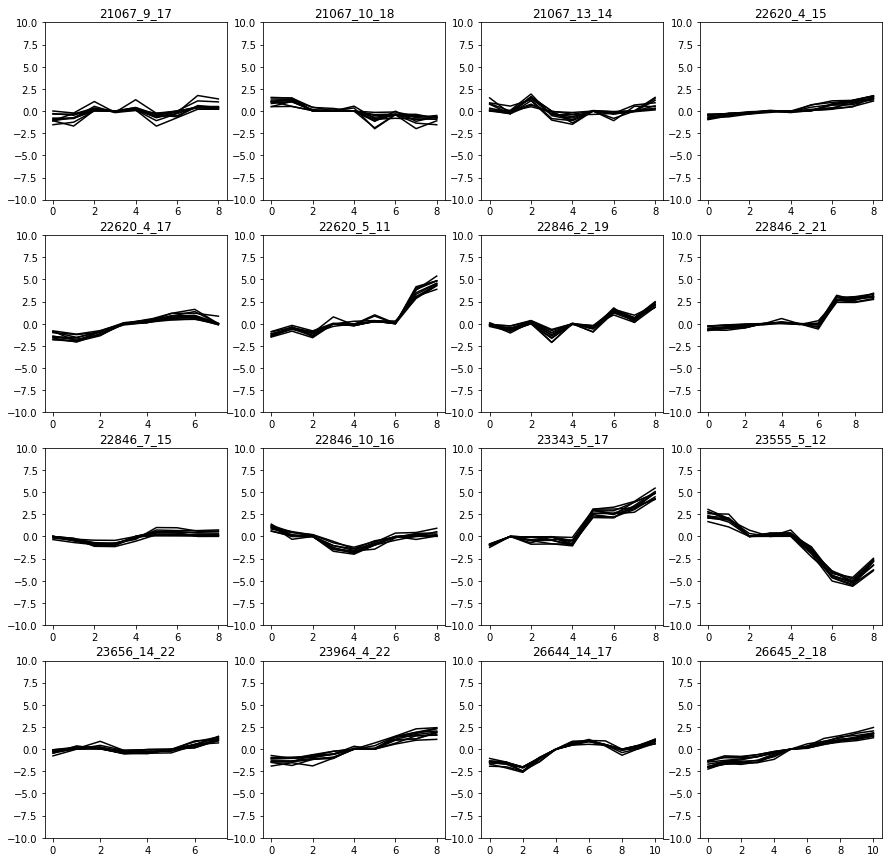

In [68]:
fig,axes = plt.subplots(4,4,figsize=(15,15))
axes = np.concatenate(axes)
for ax,rot_key in zip(axes,rot_keys):
    regot = stack.RegistrationOverTime.Affine & rot_key
    for field in (dj.U('field') & regot).fetch('field'):
        zs = (regot & {'field':field}).fetch('reg_z',order_by = 'frame_num ASC')
        ax.plot(zs - np.nanmedian(zs),'k')
    ax.set_ylim([-10,10])
    ax.set_title('_'.join([str(v) for v in (rot_key['animal_id'], rot_key['scan_session'], rot_key['scan_idx'])]))
    

# Stack Parameters

In [27]:
fetch_str = stack.StackInfo.ROI.heading.secondary_attributes[5:11]


px_d,px_h,px_w,um_d,um_h,um_w = (stack.StackInfo.ROI & stack_keys).fetch(*fetch_str)
print('stack parameters across all stacks')
print('depth: ',set(px_d),' pixels, ', set(um_d), ' microns', set(px_d/um_d), ' px/um resolution')
print('height: ',set(px_h),' pixels, ', set(um_h), ' microns', set(px_h/um_h), ' px/um resolution')
print('width: ',set(px_w),' pixels, ', set(um_w), ' microns', set(px_w/um_w), ' px/um resolution')
print('\n')

# for stack_key in stack_keys:    
#     px_d,px_h,px_w,um_d,um_h,um_w = (stack.StackInfo.ROI & stack_key).fetch(*fetch_str)
#     print(stack_key)
#     print('depth: ',set(px_d),' pixels, ', set(um_d), ' microns', set(px_d/um_d), ' px/um resolution')
#     print('height: ',set(px_h),' pixels, ', set(um_h), ' microns', set(px_h/um_h), ' px/um resolution')
#     print('width: ',set(px_w),' pixels, ', set(um_w), ' microns', set(px_w/um_w), ' px/um resolution')
#     print('\n')

across all stacks
depth:  {150}  pixels,  {150.0}  microns {1.0}  px/um resolution
height:  {640}  pixels,  {800.0}  microns {0.8}  px/um resolution
width:  {400}  pixels,  {500.0}  microns {0.8}  px/um resolution




In [60]:
promoted_width_rel = dj.U(*stack.CorrectedStack.heading.primary_key,'px_width') * (stack.CorrectedStack & stack_keys)
width_comp_rel = promoted_width_rel.aggr(stack.StackInfo.ROI & stack_keys,sum_roi_width = 'SUM(roi_px_width)')

volume_widths, field_width_sums = width_comp_rel.fetch('px_width','sum_roi_width')

stack_overlaps = sorted((field_width_sums - volume_widths).astype('float'))
print('median overlap: ', np.median(stack_overlaps))

median overlap:  156.0


In [ ]:
# stackset_rel = (stack.StackSet.Match & 
#                 {'animal_id':17797,'stack_session':9, 'stack_idx':19} & 
#                 nda.ScanInclude.proj(scan_session='session'))

# print(len(set(stackset_rel.fetch('munit_id'))))